In [1]:
import sys
sys.path.append('../')

from typing import Union, Tuple
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import copy

from src.utils import get_data_and_feed
from scipy.integrate import odeint

import torch
import torch.nn as nn
from tqdm import tqdm 

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
# DEVICE = 'cpu'
print(DEVICE)

cuda


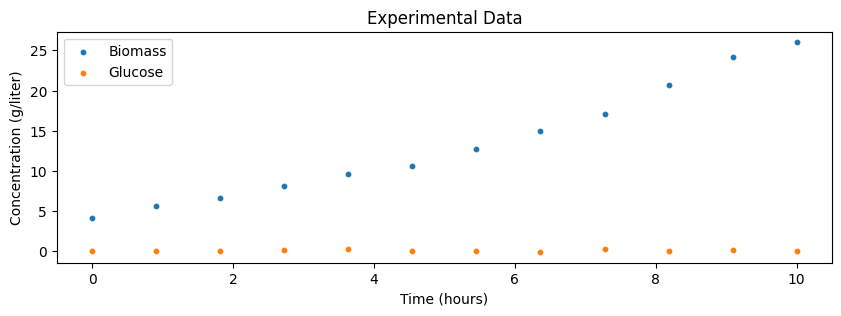

In [2]:
T_START = 0
T_END = 10
NUM_SAMPLES = 12
S0 = 0.01
X0 = 4.16
V0 = 1.55

# parameter values
mumax = 0.84     # 1/hour
Ks = 0.2          # g/liter
Yxs = 0.5         # g/g
Sin = 1.43 * 200  # g/liter

# inlet flowrate
def Fs(t):
    if t <= 4.73:
        return 0.017
    elif t <= 7.33:
        return 0.031
    elif t <= 9.17:
        return 0.060
    elif t <= 9.78:
        return 0.031
    else:
        return 0.017

def simulate(mumax, Ks, Yxs, Sin, T_START, T_END, NUM_SAMPLES):
    
    mumax = mumax
    Ks = Ks
    Yxs = Yxs
    
    # reaction rates
    def mu(S):
        return mumax*S/(Ks + S)

    def Rg(X,S):
        return mu(S)*X

    # differential equations
    def xdot(x,t):
        X,S,V = x
        dX = -Fs(t)*X/V + Rg(X,S)
        dS = Fs(t)*(Sin-S)/V - Rg(X,S)/Yxs
        dV = Fs(t)
        return [dX,dS,dV]

    IC = [X0, S0, V0]

    t = np.linspace(T_START,T_END,NUM_SAMPLES)
    sol = odeint(xdot,IC,t)

    return sol

X,S,V = simulate(mumax, Ks, Yxs, Sin, T_START, T_END, NUM_SAMPLES).transpose()

# Generate dataset 
t = np.linspace(T_START,T_END,NUM_SAMPLES)
full_df = pd.DataFrame({'RTime': t, 'Biomass': X, 'Glucose': S, 'V': V})

# Add smal noise to BIomass and Glucose
full_df['Biomass'] = full_df['Biomass'] + np.random.normal(0,0.2,NUM_SAMPLES)
full_df['Glucose'] = full_df['Glucose'] + np.random.normal(0,0.1,NUM_SAMPLES)

# Plot 
plt.figure(figsize=(10,3))  
plt.scatter(t,full_df['Biomass'],s=10,label='Biomass')
plt.scatter(t,full_df['Glucose'],s=10,label='Glucose')
plt.xlabel('Time (hours)')
plt.ylabel('Concentration (g/liter)')
plt.title('Experimental Data')
plt.legend()
plt.show()

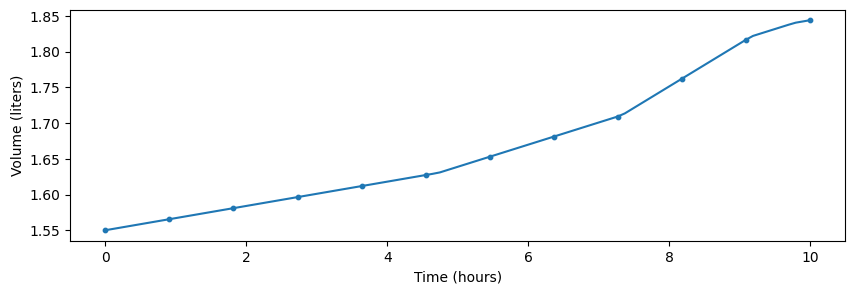

In [3]:
def Fs(t):
    if t <= 4.73:
        return 0.017
    elif t <= 7.33:
        return 0.031
    elif t <= 9.17:
        return 0.060
    elif t <= 9.78:
        return 0.031
    else:
        return 0.017

def integrate_Fs(a, b):
    integral = 0
    if b <= 4.73:
        integral = 0.017 * (b - a)
    elif a <= 4.73 < b <= 7.33:
        integral = 0.017 * (4.73 - a) + 0.031 * (b - 4.73)
    elif a <= 4.73 < b <= 9.17:
        integral = 0.017 * (4.73 - a) + 0.031 * (7.33 - 4.73) + 0.060 * (b - 7.33)
    elif a <= 4.73 < b <= 9.78:
        integral = 0.017 * (4.73 - a) + 0.031 * (7.33 - 4.73) + 0.060 * (9.17 - 7.33) + 0.031 * (b - 9.17)
    elif a <= 4.73 < b:
        integral = 0.017 * (4.73 - a) + 0.031 * (7.33 - 4.73) + 0.060 * (9.17 - 7.33) + 0.031 * (9.78 - 9.17) + 0.017 * (b - 9.78)
    elif 4.73 < a <= 7.33 < b <= 9.17:
        integral = 0.031 * (7.33 - a) + 0.060 * (b - 7.33)
    elif 4.73 < a <= 7.33 < b <= 9.78:
        integral = 0.031 * (7.33 - a) + 0.060 * (9.17 - 7.33) + 0.031 * (b - 9.17)
    elif 4.73 < a <= 7.33 < b:
        integral = 0.031 * (7.33 - a) + 0.060 * (9.17 - 7.33) + 0.031 * (9.78 - 9.17) + 0.017 * (b - 9.78)
    elif 7.33 < a <= 9.17 < b <= 9.78:
        integral = 0.060 * (9.17 - a) + 0.031 * (b - 9.17)
    elif 7.33 < a <= 9.17 < b:
        integral = 0.060 * (9.17 - a) + 0.031 * (9.78 - 9.17) + 0.017 * (b - 9.78)
    elif 9.17 < a <= 9.78 < b:
        integral = 0.031 * (9.78 - a) + 0.017 * (b - 9.78)
    elif 9.17 < a <= 9.78 and b <= 9.78:
        integral = 0.031 * (b - a)
    elif 9.78 < a and 9.78 < b:
        integral = 0.017 * (b - a)
    return integral

def V(t):
    if t <= 4.73:
        return integrate_Fs(0, t) + V0
    elif t <= 7.33:
        return integrate_Fs(0, 4.73) + integrate_Fs(4.73, t) + V0
    elif t <= 9.17:
        return integrate_Fs(0, 4.73) + integrate_Fs(4.73, 7.33) + integrate_Fs(7.33, t) + V0
    elif t <= 9.78:
        return integrate_Fs(0, 4.73) + integrate_Fs(4.73, 7.33) + integrate_Fs(7.33, 9.17) + integrate_Fs(9.17, t) + V0
    else:
        return integrate_Fs(0, 4.73) + integrate_Fs(4.73, 7.33) + integrate_Fs(7.33, 9.17) + integrate_Fs(9.17, 9.78) + integrate_Fs(9.78, t) + V0
    

t_sim = np.linspace(0,10,100)
V_data = [V(t) for t in t_sim]

plt.figure(figsize=(10,3))  
plt.scatter(t,full_df['V'],s=10,label='Volume')
plt.plot(t_sim,V_data,label='Volume (true)')
plt.xlabel('Time (hours)')
plt.ylabel('Volume (liters)')
plt.show()

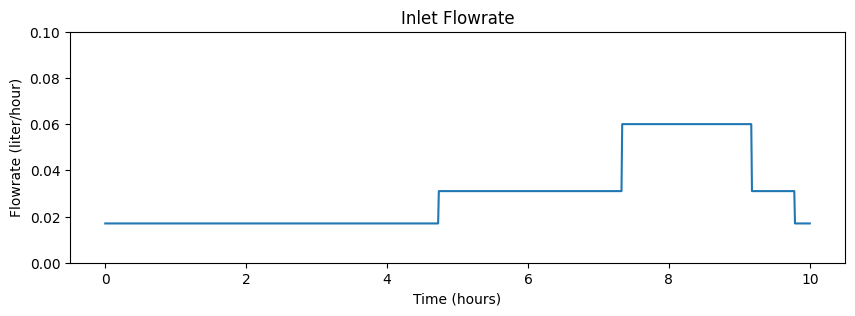

In [4]:
# Plot Fs(t) 
Fs_t = [Fs(i) for i in np.linspace(T_START,T_END,1000)]
plt.figure(figsize=(10,3))
plt.plot(np.linspace(T_START,T_END,1000),Fs_t)
plt.xlabel('Time (hours)')
plt.ylabel('Flowrate (liter/hour)')
plt.title('Inlet Flowrate')
plt.ylim(0,0.1)
plt.show()

In [5]:
def numpy_to_tensor(array):
    return (
        torch.tensor(array, requires_grad=True, dtype=torch.float32)
        .to(DEVICE)
        .reshape(-1, 1)
    )

class PINN(nn.Module):
    def __init__(
        self,
        input_dim: int,
        output_dim: int,
    ):
        super().__init__()
        self.input = nn.Linear(input_dim, 10)
        self.hidden = nn.Linear(10, 50)
        self.hidden2 = nn.Linear(50, 50)
        self.hidden3 = nn.Linear(50, 10)
        self.output = nn.Linear(10, output_dim)

        self.mu_max = nn.Parameter(torch.tensor(0.5, dtype=torch.float32))
        self.K_s = nn.Parameter(torch.tensor(0.5, dtype=torch.float32))
        self.Y_xs = nn.Parameter(torch.tensor(0.5, dtype=torch.float32))
        
    def forward(self, x):
        x = torch.relu(self.input(x))
        x = torch.relu(self.hidden(x))
        x = torch.relu(self.hidden2(x))
        x = torch.relu(self.hidden3(x))
        x = self.output(x)
        return x

def grad(outputs, inputs):
    """Computes the partial derivative of 
    an output with respect to an input.
    Args:
        outputs: (N, 1) tensor
        inputs: (N, D) tensor
    """
    return torch.autograd.grad(
        outputs, inputs, grad_outputs=torch.ones_like(outputs), create_graph=True
    )

def loss_fn(
    net: torch.nn.Module,
    t_start: Union[np.float32, torch.Tensor],
    t_end: Union[np.float32, torch.Tensor],
) -> torch.Tensor:
    
    t = torch.linspace(t_start, t_end, steps=50,).view(-1, 1).requires_grad_(True).to(DEVICE)

    F = torch.tensor([Fs(i) for i in t]).view(-1, 1).to(DEVICE)
    
    u_pred = net.forward(t)
    X_pred = u_pred[:, 0].view(-1, 1)
    S_pred = u_pred[:, 1].view(-1, 1)
    V_pred = torch.tensor([V(i) for i in t], requires_grad=True).view(-1, 1).to(DEVICE)

    
    dXdt_pred = grad(X_pred, t)[0]
    dSdt_pred = grad(S_pred, t)[0]

    mu = net.mu_max * S_pred / (net.K_s + S_pred)

    error_dXdt = (dXdt_pred - mu * X_pred + X_pred * F / V_pred) 
    error_dSdt = (dSdt_pred + mu * X_pred / net.Y_xs - F / V_pred * (Sin - S_pred)) 

    error_ode = torch.mean(error_dXdt**2 + error_dSdt**2) # + error_dVdt**2)
    return error_ode


In [6]:
print(f'Full dataset size: {full_df.shape[0]}')

Full dataset size: 12


In [7]:
TRAIN_SIZE = 11
df = full_df.iloc[:TRAIN_SIZE].copy()
t_start = df['RTime'].iloc[0]
t_end = df['RTime'].iloc[-1]
t_train = df['RTime'].values

In [8]:
t_train = numpy_to_tensor(t_train).to(DEVICE)
Biomass_train = numpy_to_tensor(df["Biomass"].values).to(DEVICE)
Glucose_train = numpy_to_tensor(df["Glucose"].values).to(DEVICE)
u_train = torch.cat((Biomass_train, Glucose_train), 1).to(DEVICE)
net = PINN(1,2).to(DEVICE)

optimizer = torch.optim.Adam(net.parameters(), lr=1e-4) #, weight_decay=1e-6)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.1)

def train(net, optimizer, t_train, u_train):
    print(f'Training dataset size: {t_train.shape[0]}')
    # Initialize early stopping variables
    best_loss = float('inf')
    best_model_weights = None
    patience = 100

    num_epochs = 10000
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        u_pred = net.forward(t_train)
        
        # Data loss
        X_data_loss = nn.MSELoss()(u_pred[:,0], u_train[:,0])
        S_data_loss = nn.MSELoss()(u_pred[:,1], u_train[:,1])
        loss_data = (X_data_loss + S_data_loss) 
        
        # IC loss
        X_ic_loss = nn.MSELoss()(u_pred[0,0], u_train[0,0])
        S_ic_loss = nn.MSELoss()(u_pred[0,1], u_train[0,1])
        loss_ic = (X_ic_loss + S_ic_loss) 
        
        # ODE loss
        loss_ode = loss_fn(net, t_start, t_end) 
        
        # # Total Loss
        loss = loss_data + loss_ic + loss_ode
        loss.backward()

        # torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=1.0)

        optimizer.step()
        # scheduler.step()
        
        if epoch % 100 == 0:
            print(f"Epoch {epoch} | Loss: {loss.item():.4f} data loss: {loss_data.item():.4f}, IC loss: {loss_ic.item():.4f}, ODE loss: {loss_ode.item():.4f}")
            print(f"mu_max: {net.mu_max.item():.4f}, K_s: {net.K_s.item():.4f}, Y_xs: {net.Y_xs.item():.4f}")

        if loss < best_loss :
            best_loss = loss
            best_model_weights = copy.deepcopy(net.state_dict())
            patience = 100
        else:
            patience -= 1
            if patience == 0:
                print(f"Early stopping at epoch {epoch}")   
                net.load_state_dict(best_model_weights)
                break  
            
    t_test = torch.linspace(T_START, T_END, 1000).view(-1, 1).to(DEVICE)
    net_df = pd.DataFrame()
    net_df['RTime'] = t_test.cpu().detach().numpy().flatten()   
    net_df['Biomass'] = net(t_test).cpu().detach().numpy()[:,0]
    net_df['Glucose'] = net(t_test).cpu().detach().numpy()[:,1]
    
    return net, net_df, loss

In [9]:
net, net_df, loss = train(net, optimizer, t_train, u_train)

Training dataset size: 11
Epoch 0 | Loss: 247.8864 data loss: 194.6275, IC loss: 20.5090, ODE loss: 32.7499
mu_max: 0.4999, K_s: 0.5001, Y_xs: 0.5001
Epoch 100 | Loss: 237.0575 data loss: 186.1187, IC loss: 19.9207, ODE loss: 31.0180
mu_max: 0.4937, K_s: 0.5064, Y_xs: 0.5063
Epoch 200 | Loss: 220.1833 data loss: 173.9278, IC loss: 18.8230, ODE loss: 27.4325
mu_max: 0.5075, K_s: 0.4948, Y_xs: 0.4924
Epoch 300 | Loss: 185.6874 data loss: 150.3993, IC loss: 16.8457, ODE loss: 18.4424
mu_max: 0.5292, K_s: 0.4751, Y_xs: 0.4701
Epoch 400 | Loss: 130.1600 data loss: 110.3265, IC loss: 13.5813, ODE loss: 6.2522
mu_max: 0.5484, K_s: 0.4586, Y_xs: 0.4494
Epoch 500 | Loss: 77.7930 data loss: 63.3267, IC loss: 9.4661, ODE loss: 5.0003
mu_max: 0.5491, K_s: 0.4577, Y_xs: 0.4424
Epoch 600 | Loss: 38.7043 data loss: 26.8109, IC loss: 5.7221, ODE loss: 6.1714
mu_max: 0.5252, K_s: 0.4817, Y_xs: 0.4602
Epoch 700 | Loss: 8.3639 data loss: 3.5465, IC loss: 2.4510, ODE loss: 2.3664
mu_max: 0.5203, K_s: 0.48

In [10]:
print(f'Loss: {loss.item():.4f}')
print(f'mu_max: {net.mu_max.item():.4f}, K_s: {net.K_s.item():.4f}, Y_xs: {net.Y_xs.item():.4f}')

Loss: 0.9733
mu_max: 0.6599, K_s: 0.2419, Y_xs: 0.4527


In [11]:
t_test = np.linspace(T_START,T_END,1000)
X_test,S_test,V_test = simulate(net.mu_max.item(), net.K_s.item(), net.Y_xs.item(), Sin, T_START, T_END, 1000).transpose()

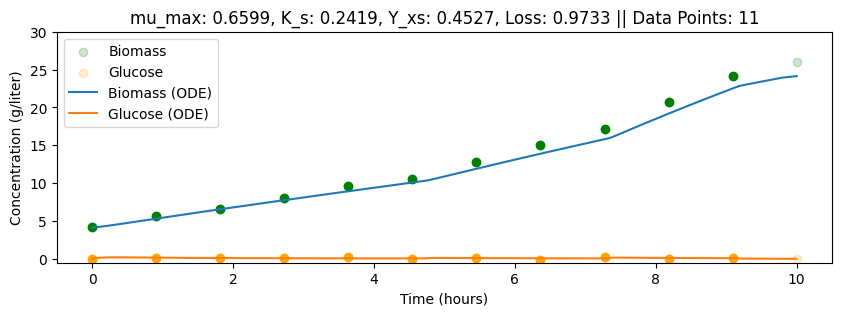

In [12]:
plt.figure(figsize=(10,3))
plt.scatter(full_df['RTime'],full_df['Biomass'],label='Biomass', color='green', alpha=0.2)
plt.scatter(full_df['RTime'],full_df['Glucose'],label='Glucose', color='orange', alpha=0.2)
plt.scatter(df['RTime'],df['Biomass'],label='_Biomass', color='green', alpha=1.0)
plt.scatter(df['RTime'],df['Glucose'],label='_Glucose', color='orange', alpha=1.0)

# plt.plot(net_df['RTime'],net_df['Biomass'],label='Biomass (PINN)', linestyle='--', color='black', alpha=0.5)
# plt.plot(net_df['RTime'],net_df['Glucose'],label='Glucose (PINN)', linestyle='--', color='red', alpha=0.5)

plt.plot(t_test,X_test,label='Biomass (ODE)')
plt.plot(t_test,S_test,label='GlWWucose (ODE)')
plt.xlabel('Time (hours)')
plt.ylabel('Concentration (g/liter)')
plt.ylim(-0.5,30)
plt.legend()
plt.title(f'mu_max: {net.mu_max.item():.4f}, K_s: {net.K_s.item():.4f}, Y_xs: {net.Y_xs.item():.4f}, Loss: {loss.item():.4f} || Data Points: {TRAIN_SIZE}')
plt.savefig(f'../plots/fed_batch_{TRAIN_SIZE}.png')
plt.show()

In [13]:
net_df

,RTime,Biomass,Glucose
0,0.00000,4.225708,0.158260
1,0.01001,4.238864,0.159908
2,0.02002,4.252036,0.161556
3,0.03003,4.265445,0.163283
4,0.04004,4.279948,0.165373
...,...,...,...
995,9.95996,26.156233,0.112146
996,9.96997,26.186726,0.112279
997,9.97998,26.217218,0.112411
998,9.98999,26.247719,0.112545
